Здесь мы обучаем T-learner по бустингу и логрегрессии, которые будут подобраны по гиперпараметрам с помощью optuna.    

Суть T-learner: на двух выборках по тритмент и контрольной группе оцениваем для каждого X P(Y=1|X=x,T=1 или 0) и смотрим на разницу вероятностей как на конечный аплифт.    

То есть происходи аппроксимация индивидуального причинного эффекта - определяя пользу от воздействия.

Ниже sklift.viz как полагаю ругается на наличие или или отсутствие библиотеки, поэтому настроим функцию чекера:

In [1]:
import sklearn.utils

def check_matplotlib_support(caller_name):
    try:
        import matplotlib
    except ImportError:
        raise ImportError(
            "Matplotlib is required for plotting functions in " + caller_name
        )

setattr(sklearn.utils, 'check_matplotlib_support', check_matplotlib_support)

In [2]:
import gc
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklift.datasets import fetch_x5
from sklift.models import TwoModels
from sklift.metrics import uplift_auc_score, qini_auc_score
import optuna
from feature_extraction import UpliftFeatureExtractor
import matplotlib.pyplot as plt

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve, plot_qini_curve


Бустинги выводят свои логи и ошибки, мешая читаемости выкладок по результатам обучения, поэтому пропустим их (насколько они состоятельны и реально показывают проблему оценили):

In [3]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
dataset = fetch_x5()
data = dataset.data

In [5]:
# подсчет фич
extractor = UpliftFeatureExtractor(drop_redundant=True)
df = extractor.calculate_features(
    clients_df=data.clients,
    train_df=data.train,
    treatment_df=dataset.treatment,
    target_df=dataset.target,
    purchases_df=data.purchases
)

del data
gc.collect()

features = extractor.feature_names

print(f"Создано признаков: {len(features)}")
print(f"Размер датафрейма: {df.shape}")
print(f"Признаки: {features}")

Создано признаков: 32
Размер датафрейма: (200039, 34)
Признаки: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_quarter', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'gender', 'is_activated']


In [6]:
target = 'target' 
treatment = 'treatment_flg'

Процесс работы стандартный: делаем отложенную выборку для конечного теста моделей, затем создаем классы и пайплайн со стандартизацией и кодированием, поскольку данные необработанные (пайплайн, чтобы учитывал, что fit делаем на трейне, а трансформируем все на тесте в рамках CV).

In [7]:
X_raw = df[features]
y = df[target].astype(int).values
t = df[treatment].astype(int).values

NUM_COLS = X_raw.select_dtypes(include='number').columns.tolist()
CAT_COLS = X_raw.select_dtypes(include='object').columns.tolist()

print("Числовые фичи:", NUM_COLS)
print("Категориальные фичи:", CAT_COLS)

import numpy as np

strata = np.array(list(zip(df[treatment], df[target])))
# strata – массив пар (0,0), (1,0), ...

# кодируем пары в категории
_, strata_encoded = np.unique(strata, axis=0, return_inverse=True)

X_train_raw, X_test_raw, y_train, y_test, t_train, t_test = train_test_split(
    X_raw, y, t,
    test_size=0.3,
    random_state=42,
    stratify=strata_encoded # чтобы доли классов были одинаковые в выборке
)

Числовые фичи: ['first_issue_month', 'first_issue_weekday', 'first_issue_year_quarter_idx', 'total_transactions', 'avg_transaction_amount', 'max_transaction_amount', 'min_transaction_amount', 'total_express_points_received', 'total_express_points_spent', 'avg_express_points_per_transaction', 'points_earned_to_spent_ratio', 'unique_products_count', 'avg_product_quantity', 'transaction_period_days', 'first_transaction_year_quarter_idx', 'unique_stores_visited', 'store_loyalty_ratio', 'avg_purchase_per_day', 'transactions_per_month', 'points_spend_ratio', 'points_balance_ratio', 'unique_store_intensity', 'log_total_purchase_sum', 'seasonal_quarter_code', 'avg_items_per_transaction', 'spend_points_per_transaction', 'transaction_value_density', 'is_super_loyal', 'age', 'is_activated']
Категориальные фичи: ['first_transaction_quarter']


Определим наши модели и набор параметров для оптимизации. 

In [8]:
def build_preprocessor():

    transformers = []
    if len(NUM_COLS) > 0:
        transformers.append(
            ("num", StandardScaler(), NUM_COLS)
        )
    if len(CAT_COLS) > 0:
        transformers.append(
            ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS)
        )

    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop"
    )
    return preprocessor


# Базовые классификаторы с гиперпараметрами - что вообще должна подбирать оптуна

def build_base_estimator(model_name: str, params: dict) -> Pipeline:

    preprocessor = build_preprocessor()

    if model_name == 'logreg':
        clf = LogisticRegression(
            C=params['C'],
            class_weight=params['class_weight'],
            penalty='l2',
            solver='lbfgs',
            max_iter=2000,
            n_jobs=-1
        )

    elif model_name == 'rf':
        clf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            min_samples_split=params['min_samples_split'],
            n_jobs=-1,
            random_state=42
        )

    elif model_name == 'xgb':
        clf = XGBClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            objective='binary:logistic',
            eval_metric='logloss',
            n_jobs=-1,
            tree_method='hist',
            random_state=42,
            verbosity=0
        )

    elif model_name == 'lgbm':
        clf = LGBMClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            num_leaves=params['num_leaves'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            reg_lambda=params['reg_lambda'],
            objective='binary',
            n_jobs=-1,
            random_state=42,
            verbose=-1
        )

    elif model_name == 'catboost':
        clf = CatBoostClassifier(
            depth=params['depth'],
            learning_rate=params['learning_rate'],
            l2_leaf_reg=params['l2_leaf_reg'],
            iterations=params['iterations'],
            subsample=params['subsample'],
            bagging_temperature=params['bagging_temperature'],
            loss_function='Logloss',
            eval_metric='Logloss',
            verbose=False,
            random_seed=42,
            thread_count=-1
        )

    else:
        raise ValueError(f"Неизвестная модель: {model_name}")

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", clf)
        ]
    )
    return pipe

Для optuna по подбираемым параметрам определяем их диапозоны (выбрали часто встречаемые в анализе), разбиение на CV для внутренней валидации по выборке трейна, а также саму TwoModels (sklift) и метрику, по которой выбирается конечная лучшая модель (условились на AUUC, обоснование см. на заключительном анализе по моделированию). Функцию ниже optuna будет вызывать каждый трайл, в котором будет обозначаться один набор гиперпараметров, по которому будет проходить кросс-валидация на метрике и призводиться обучение модели по архитектуре TwoModels. К-фолд взяли n=3, чтобы не грузить и без того длительное обучение и подбор.

In [9]:
def make_objective(model_name: str,
                   X: pd.DataFrame,
                   y: np.ndarray,
                   t: np.ndarray,
                   n_splits: int = 3):

    X_df = X.copy()

    def objective(trial: optuna.Trial) -> float:
        if model_name == 'logreg':
            params = {
                'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
                'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            }

        elif model_name == 'rf':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 600, step=100),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            }

        elif model_name == 'xgb':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 150, 700, step=50),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            }

        elif model_name == 'lgbm':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 150, 700, step=50),
                'max_depth': trial.suggest_int('max_depth', -1, 15),
                'num_leaves': trial.suggest_int('num_leaves', 16, 128),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            }

        elif model_name == 'catboost':
            params = {
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
                'iterations': trial.suggest_int('iterations', 200, 800, step=100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
            }

        else:
            raise ValueError(f"Неизвестная модель: {model_name}")

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=42
        )

        scores = []

        for train_idx, val_idx in skf.split(X_df, y):
            X_tr = X_df.iloc[train_idx]
            X_val = X_df.iloc[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            t_tr, t_val = t[train_idx], t[val_idx]

            # две базовые модели для T-learner
            base_trmnt = build_base_estimator(model_name, params)
            base_ctrl = build_base_estimator(model_name, params)

            tm = TwoModels(
                estimator_trmnt=base_trmnt,
                estimator_ctrl=base_ctrl,
                method='vanilla'
            )

            tm.fit(X_tr, y_tr, t_tr)

            uplift_val = tm.predict(X_val)  # uplift-скор

            score = uplift_auc_score(
                y_true=y_val,
                uplift=uplift_val,
                treatment=t_val
            )
            scores.append(score)
        
        mean_score = float(np.mean(scores))

        print(f"[{model_name}] Trial {trial.number}: AUUC={mean_score:.6f}, params={params}")

        return mean_score

    return objective


Переходим к процессу подбора. Всего будет 10 трайлов по каждой модели (немного и немало, средне).

In [10]:
MODEL_TYPES = ['logreg', 'rf', 'xgb', 'lgbm', 'catboost']

N_TRIALS = {
    'logreg': 10,
    'rf': 10,
    'xgb': 10,
    'lgbm': 10,
    'catboost': 10,
}

studies = {}
cv_results = []

for model_name in MODEL_TYPES:
    print(f"\n-------------- Подбор {model_name} --------------")

    study = optuna.create_study( # что оптимизируем
        direction="maximize",
        study_name=f"t_learner_{model_name}_auuc"
    )

    study.optimize( # какая модель с какими параметрами
        make_objective(
            model_name=model_name,
            X=X_train_raw,
            y=y_train,
            t=t_train,
            n_splits=3
        ),
        n_trials=N_TRIALS[model_name]
    )

    print(f"{model_name} лучший AUUC по CV: {study.best_value:.6f}")
    print(f"{model_name} лучшие параметры: {study.best_params}")

    studies[model_name] = study
    cv_results.append({
        "model_type": model_name,
        "best_cv_auuc": study.best_value,
        "best_params": study.best_params
    })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values("best_cv_auuc", ascending=False)
print("\n-------------- Результаты по моделям: --------------")
display(cv_results_df)


-------------- Подбор logreg --------------
[logreg] Trial 0: AUUC=0.024410, params={'C': 2.1741286418768726, 'class_weight': None}
[logreg] Trial 1: AUUC=0.023753, params={'C': 0.07819755716843134, 'class_weight': 'balanced'}
[logreg] Trial 2: AUUC=0.024438, params={'C': 0.027301853380688412, 'class_weight': None}
[logreg] Trial 3: AUUC=0.023741, params={'C': 0.10611410188128695, 'class_weight': 'balanced'}
[logreg] Trial 4: AUUC=0.023764, params={'C': 1.9096935861737905, 'class_weight': 'balanced'}
[logreg] Trial 5: AUUC=0.024047, params={'C': 0.0070283048017589006, 'class_weight': 'balanced'}
[logreg] Trial 6: AUUC=0.024103, params={'C': 0.004258309558764671, 'class_weight': 'balanced'}
[logreg] Trial 7: AUUC=0.023765, params={'C': 3.645914843805433, 'class_weight': 'balanced'}
[logreg] Trial 8: AUUC=0.023765, params={'C': 29.002408755435198, 'class_weight': 'balanced'}
[logreg] Trial 9: AUUC=0.023960, params={'C': 0.013685860244374806, 'class_weight': 'balanced'}
logreg лучший AUU

,model_type,best_cv_auuc,best_params
0,logreg,0.024438,"{'C': 0.027301853380688412, 'class_weight': None}"
4,catboost,0.022979,"{'depth': 9, 'learning_rate': 0.01032750278725..."
2,xgb,0.021613,"{'n_estimators': 250, 'max_depth': 6, 'learnin..."
3,lgbm,0.018496,"{'n_estimators': 400, 'max_depth': 2, 'num_lea..."
1,rf,0.017857,"{'n_estimators': 400, 'max_depth': 7, 'min_sam..."


Сравним на тестовых данных:

In [11]:
final_models = []

KS = [0.1, 0.2, 0.3, 0.5] # для upliftk

for row in cv_results:
    model_name = row["model_type"]
    best_params = row["best_params"]

    print(f"\n-------------- Обучение {model_name} --------------")

    base_trmnt = build_base_estimator(model_name, best_params)
    base_ctrl = build_base_estimator(model_name, best_params)

    tm = TwoModels(
        estimator_trmnt=base_trmnt,
        estimator_ctrl=base_ctrl,
        method='vanilla'
    )

    # обучаем на всём train
    tm.fit(X_train_raw, y_train, t_train)

    # uplift-скор на тесте
    uplift_test = tm.predict(X_test_raw)

    # AUUC и Qini
    auuc_test = uplift_auc_score(
        y_true=y_test,
        uplift=uplift_test,
        treatment=t_test
    )
    qini_test = qini_auc_score(
        y_true=y_test,
        uplift=uplift_test,
        treatment=t_test
    )

    # Uplift@k для каждого k
    uplift_k_scores = {}
    for k in KS:
        u_k = uplift_at_k(
            y_true=y_test,
            uplift=uplift_test,
            treatment=t_test,
            strategy="overall",
            k=k
        )
        uplift_k_scores[f"uplift_at_{int(k*100)}"] = u_k

    # лог в консоль
    print(f"{model_name}: тест AUUC = {auuc_test:.6f}, тест Qini = {qini_test:.6f}")
    for k in KS:
        key = f"uplift_at_{int(k*100)}"
        print(f"  {model_name}: Uplift@{int(k*100)}% = {uplift_k_scores[key]:.6f}")

    # сохраняем всё в final_models
    model_record = {
        "model_type": model_name,
        "model": tm,
        "test_auuc": auuc_test,
        "test_qini": qini_test,
    }
    model_record.update(uplift_k_scores)
    final_models.append(model_record)

# собираем таблицу с результатами
test_results_df = pd.DataFrame([
    {
        "model_type": m["model_type"],
        "best_cv_auuc": studies[m["model_type"]].best_value,
        "test_auuc": m["test_auuc"],
        "test_qini": m["test_qini"],
        "uplift_at_10": m.get("uplift_at_10"),
        "uplift_at_20": m.get("uplift_at_20"),
        "uplift_at_30": m.get("uplift_at_30"),
        "uplift_at_50": m.get("uplift_at_50"),
    }
    for m in final_models
])

test_results_df = test_results_df.sort_values("test_auuc", ascending=False)
print(f"-------------- Результаты по моделям: --------------")
display(test_results_df)

best_model_row = test_results_df.iloc[0]
best_model_name = best_model_row["model_type"]
print("\n-------------- Лучшая модель: --------------")
print(f"Как зовут тебя, воин: {best_model_name}")
print(f"CV AUUC: {best_model_row['best_cv_auuc']:.8f}")
print(f"test AUUC: {best_model_row['test_auuc']:.8f}")
print(f"test Qini: {best_model_row['test_qini']:.8f}")
print(f"Uplift@10%: {best_model_row['uplift_at_10']:.8f}")
print(f"Uplift@20%: {best_model_row['uplift_at_20']:.8f}")
print(f"Uplift@30%: {best_model_row['uplift_at_30']:.8f}")
print(f"Uplift@50%: {best_model_row['uplift_at_50']:.8f}")

best_model_obj = next(
    m["model"] for m in final_models if m["model_type"] == best_model_name
) # сохраняем красавца


-------------- Обучение logreg --------------
logreg: тест AUUC = 0.019362, тест Qini = 0.012652
  logreg: Uplift@10% = 0.108821
  logreg: Uplift@20% = 0.071711
  logreg: Uplift@30% = 0.057899
  logreg: Uplift@50% = 0.047868

-------------- Обучение rf --------------
rf: тест AUUC = 0.015890, тест Qini = 0.010468
  rf: Uplift@10% = 0.087925
  rf: Uplift@20% = 0.065073
  rf: Uplift@30% = 0.055681
  rf: Uplift@50% = 0.045311

-------------- Обучение xgb --------------
xgb: тест AUUC = 0.007717, тест Qini = 0.005204
  xgb: Uplift@10% = 0.086247
  xgb: Uplift@20% = 0.057328
  xgb: Uplift@30% = 0.045218
  xgb: Uplift@50% = 0.040734

-------------- Обучение lgbm --------------
lgbm: тест AUUC = 0.014550, тест Qini = 0.009623
  lgbm: Uplift@10% = 0.084882
  lgbm: Uplift@20% = 0.058177
  lgbm: Uplift@30% = 0.050977
  lgbm: Uplift@50% = 0.042958

-------------- Обучение catboost --------------
catboost: тест AUUC = 0.013493, тест Qini = 0.008972
  catboost: Uplift@10% = 0.083033
  catboost: Up

,model_type,best_cv_auuc,test_auuc,test_qini,uplift_at_10,uplift_at_20,uplift_at_30,uplift_at_50
0,logreg,0.024438,0.019362,0.012652,0.108821,0.071711,0.057899,0.047868
1,rf,0.017857,0.015890,0.010468,0.087925,0.065073,0.055681,0.045311
3,lgbm,0.018496,0.014550,0.009623,0.084882,0.058177,0.050977,0.042958
4,catboost,0.022979,0.013493,0.008972,0.083033,0.063283,0.057098,0.041180
2,xgb,0.021613,0.007717,0.005204,0.086247,0.057328,0.045218,0.040734



-------------- Лучшая модель: --------------
Как зовут тебя, воин: logreg
CV AUUC: 0.02443769
test AUUC: 0.01936191
test Qini: 0.01265216
Uplift@10%: 0.10882141
Uplift@20%: 0.07171129
Uplift@30%: 0.05789878
Uplift@50%: 0.04786846


Что показывают uplift-метрики

AUUC (Area Under Uplift Curve)
Площадь под кривой uplift.
Отражает общее качество ранжирования: насколько модель в среднем поднимает uplift во всём диапазоне клиентов.   
Чем выше AUUC, тем лучше модель различает, где воздействие работает, а где нет.   

Qin
Похож на AUUC, но штрафует модель за плохое ранжирование сильнее и более чувствителен к локальным ошибкам.
Насколько модель действительно ранжирует лучших для воздействия клиентов вверху списка.

Uplift@k
Средний uplift среди топ-k% клиентов, которых модель считает лучшими для воздействия.   
Показывает, сколько прироста отклика даст кампания, если таргетить верхние сегменты по предсказанию модели.


AUUC около 0.02 — это низкий по абсолютной шкале uplift-сигнал, но для реальных данных это может быть норма.   
Ритейл - многофакторная отрасль, и воздействие необязательно должно повышать отклик.  

CV AUUC ≈ test AUUC → модель стабильная, она не переобучена и даёт примерно одинаковое качество на unseen данных.

Qini невысокое, но положительное и согласовано с AUUC, т.е. ранжирование есть, просто uplift-сигнал слабый сам по себе. 

Uplift@10% = 0.1088   
В верхних 10% клиентов uplift ≈ +0.11.    
То есть топ-кандидаты дают примерно 11% дополнительного отклика относительно control.
Локально модель действительно нашла сегмент, где воздействие имеет смысл. 

Uplift@20% = 0.0717   
На 20% клиентов uplift падает: сигнал размазывается, сегмент становится более средним.

Uplift@30% = 0.0579   
Всё ещё положительный uplift, но ниже.

Uplift@50% = 0.0479
Сигнал почти упал, но остаётся плюс.

Вероятно, модель сегментирует клиентов нормально, но uplift небольшой по природе данных.

Строим графики и таблицу импакта по фичам для лучшей модели:

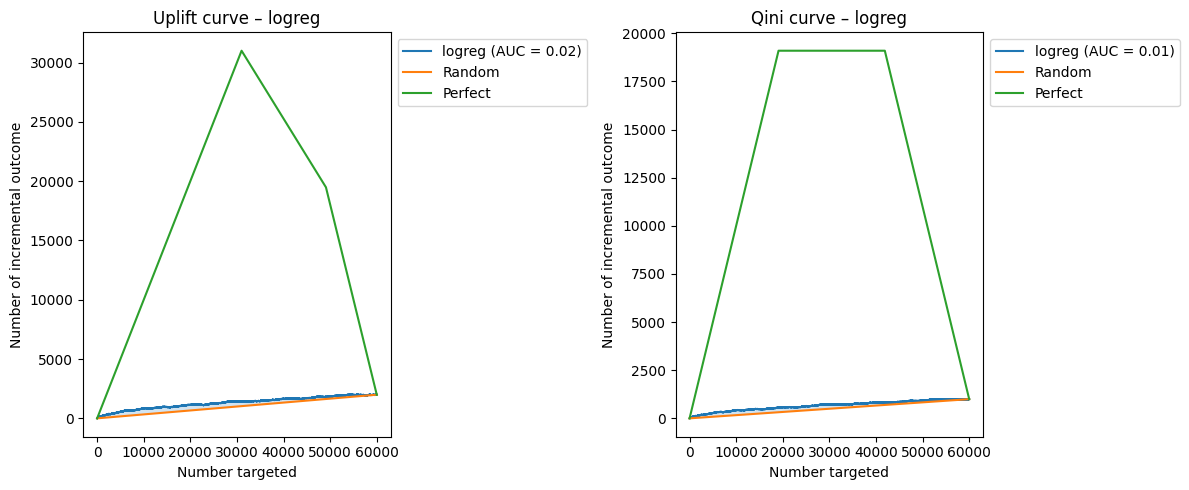

In [12]:
uplift_best_test = best_model_obj.predict(X_test_raw)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_uplift_curve(
    y_true=y_test,
    uplift=uplift_best_test,
    treatment=t_test,
    perfect=True,
    random=True,
    name=best_model_name,
    ax=axes[0],
)
axes[0].set_title(f"Uplift curve – {best_model_name}")

plot_qini_curve(
    y_true=y_test,
    uplift=uplift_best_test,
    treatment=t_test,
    perfect=True,
    random=True,
    name=best_model_name,
    ax=axes[1],
)
axes[1].set_title(f"Qini curve – {best_model_name}")

plt.tight_layout()
plt.show()


С одной стороны, модель действительно уловила влияние тритмента, поскольку отлична от случайного прогнозирования эффекта. С другой стороны, эффект оказался достаточно несущественным, чтобы утверждать действительное влияние, если мы полагаем нашу выборку адекватной и правдоподобной. В следующей проектной итерации нам следует провести дополнительно future-engeneering для нивелирования ситуации плохих данных. Однако, такие маленькие значения AUUC и Qini для ритейла могут являться допустимыми, поскольку на итоговое целевое действие (покупку\использование промокода) влияют как более значимые факторы, так и внешние, неучтенные экономические показатели, в соответствии с которыми потребительская корзина находится в постоянной динамике. Далее мы сравним выделенные нами модели и определим дальнейшую траекторию моделирования.


Топ 32 фич по влиянию на аплифт для logreg (логрег):
  cat__first_transaction_quarter_2018Q4: coef=-0.199470 (-), |coef|=0.199470
  num__log_total_purchase_sum: coef=-0.163828 (-), |coef|=0.163828
  num__points_spend_ratio: coef=0.145654 (+), |coef|=0.145654
  num__spend_points_per_transaction: coef=-0.130805 (-), |coef|=0.130805
  num__unique_products_count: coef=0.085454 (+), |coef|=0.085454
  num__transaction_period_days: coef=0.083667 (+), |coef|=0.083667
  num__total_express_points_spent: coef=0.070202 (+), |coef|=0.070202
  num__age: coef=0.063770 (+), |coef|=0.063770
  num__first_issue_year_quarter_idx: coef=0.061984 (+), |coef|=0.061984
  num__is_activated: coef=0.055484 (+), |coef|=0.055484
  num__transaction_value_density: coef=0.049379 (+), |coef|=0.049379
  num__avg_transaction_amount: coef=0.046123 (+), |coef|=0.046123
  num__avg_items_per_transaction: coef=-0.042593 (-), |coef|=0.042593
  cat__first_transaction_quarter_2019Q1: coef=-0.038902 (-), |coef|=0.038902
  num__a

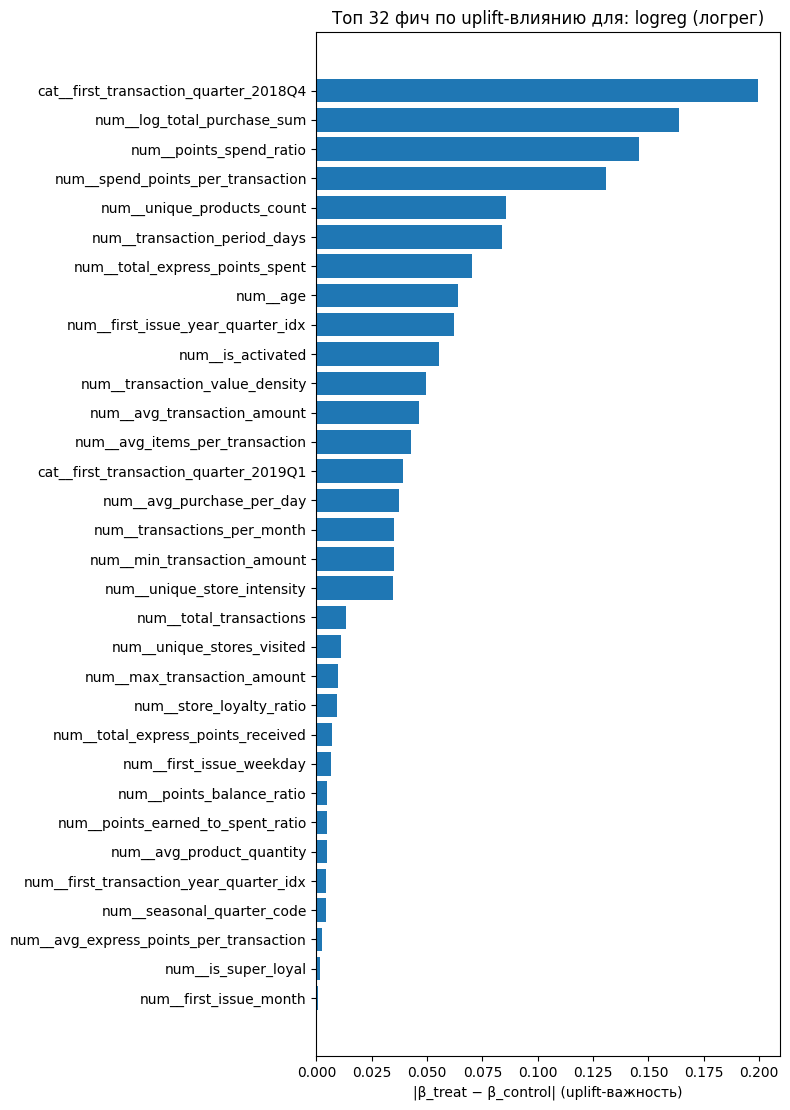

In [14]:
def get_pipeline_logreg_coefs(pipe):
    pre = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["clf"]

    # имена признаков после ColumnTransformer + OHE
    try:
        feature_names = pre.get_feature_names_out()
    except AttributeError:
        feature_names = pre.get_feature_names()

    if not hasattr(clf, "coef_"):
        raise AttributeError("Надо LogisticRegression с атрибутом coef_")

    coefs = clf.coef_.ravel()
    return np.array(feature_names), np.array(coefs)

pipe_trmnt = best_model_obj.estimator_trmnt
pipe_ctrl  = best_model_obj.estimator_ctrl

feat_names_t, coefs_t = get_pipeline_logreg_coefs(pipe_trmnt)
feat_names_c, coefs_c = get_pipeline_logreg_coefs(pipe_ctrl)

# проверяем, что порядок фич совпадает
if not np.array_equal(feat_names_t, feat_names_c):
    raise ValueError("Порядок фич в treatment и control пайплайнах не совпадает")

# разница между ветками (treat − control)
uplift_coefs = coefs_t - coefs_c          # сохраняем знак
uplift_importance = np.abs(uplift_coefs)  # модуль = сила влияния на uplift

# выбираем топ-N фич
TOP_N = 32
idx_sorted = np.argsort(uplift_importance)[::-1]
top_idx = idx_sorted[:TOP_N]

top_feat_names   = feat_names_t[top_idx]
top_uplift_coefs = uplift_coefs[top_idx]
top_uplift_abs   = uplift_importance[top_idx]

print(f"\nТоп {TOP_N} фич по влиянию на аплифт для {best_model_name} (логрег):")
for name, coef, val_abs in zip(top_feat_names, top_uplift_coefs, top_uplift_abs):
    sign = "+" if coef >= 0 else "-"
    print(f"  {name}: coef={coef:.6f} ({sign}), |coef|={val_abs:.6f}")


plt.figure(figsize=(8, max(4, TOP_N * 0.35)))
y_pos = np.arange(len(top_feat_names))
plt.barh(y_pos, top_uplift_abs)
plt.yticks(y_pos, top_feat_names)
plt.gca().invert_yaxis()
plt.xlabel("|β_treat − β_control| (uplift-важность)")
plt.title(f"Топ {TOP_N} фич по uplift-влиянию для: {best_model_name} (логрег)")
plt.tight_layout()
plt.show()

Интерпретация uplift-коэффициентов

На графике показаны признаки, которые сильнее всего влияют именно на uplift в модели T-learner.    
T-learner состоит из двух логистических регрессий:    
 • одна обучена на данных, где клиенты получили воздействие (T=1),    
 • вторая — на данных, где воздействия не было (T=0).    

Для каждого признака есть два коэффициента: коэффициент в модели для treatment и коэффициент в модели для control. Мы берём разницу между ними.  
Сами коэффициенты показывают, во сколько изменится шанс отклика ри изменении фичи на +1 стд. отклонение.   

Эта разница показывает насколько по-разному признак влияет на вероятность отклика в treatment по сравнению с control.    
Если разница положительная, значит признак сильнее двигает отклик вверх в treatment — uplift растёт.    
Если разница отрицательная, значит признак идет в пользу control — uplift снижается.    

На графике показана именно сила влияния, то есть абсолютное значение разницы между коэффициентами.    
Чем больше — тем сильнее признак влияет на uplift.     

Знак показывает, в какую сторону признак двигает uplift: увеличивает его или уменьшает.   

1. Активность и частота покупок   
У большинства активных покупателей uplift низкий или отрицательный — их baseline-поведение объясняет отклик лучше, чем воздействие. Модель видит, что ядро клиентов почти не реагирует.  

2. Структура и разнообразие покупок   
Умеренно положительный uplift: более разнообразные и разреженные по покупкам клиенты реагируют лучше.

3. Балловое поведение и лояльность   
Заметная разница между T и C: часть признаков даёт сильный uplift, часть — сильное снижение. Это главный сегмент, где воздействие действительно меняет поведение.

4. Давность / жизненный цикл клиента   
Старые клиенты почти не дают uplift или дают отрицательный, новые — положительный. Модель чётко различает эти группы.   

Несколько признаков имеют крупные uplift-коэффы — это означает, что модель ловит реальный uplift-сигнал, а не шум.   
Остальные признаки дают слабый эффект — что нормально для логрег uplift.  
Несмотря на маленькие AUUC/Qini, структура коэффициентов показывает, что модель действительно разделяет клиентов по реакции на воздействие, а не просто предсказывает отклик.

Посмотрим на параметры лучшей модели, чтобы далее ее сохранить в .py в функции вызова:

In [13]:
def print_clf_params_as_python(clf, const_name="BEST_MODEL_PARAMS"):
    params = clf.get_params()
    lines = []
    for k, v in params.items():
        lines.append(f"    {repr(k)}: {repr(v)},")
    body = "\n".join(lines)
    print(f"{const_name} = {{\n{body}\n}}\n")

pipe_trmnt = best_model_obj.estimator_trmnt
best_clf = pipe_trmnt.named_steps["clf"]

print_clf_params_as_python(best_clf, const_name="LOGREG_BEST_PARAMS")

LOGREG_BEST_PARAMS = {
    'C': 0.027301853380688412,
    'class_weight': None,
    'dual': False,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'l1_ratio': None,
    'max_iter': 2000,
    'multi_class': 'deprecated',
    'n_jobs': -1,
    'penalty': 'l2',
    'random_state': None,
    'solver': 'lbfgs',
    'tol': 0.0001,
    'verbose': 0,
    'warm_start': False,
}

